# Importing the Libraries

In [2]:

import asyncio
import edge_tts
import nest_asyncio

import io
import pygame
import edge_tts
import asyncio
import nest_asyncio
import os
from dotenv import load_dotenv
import speech_recognition as sr
from langchain_groq  import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.vectorstores import FAISS
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from typing import Literal, TypedDict, List
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver


pygame 2.6.1 (SDL 2.28.4, Python 3.12.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\Bhaumil\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
load_dotenv()
os.environ['GROQ_Key'] = os.getenv("GROQ_API_KEY") 
pygame.mixer.init()
nest_asyncio.apply()
MAX_CONCURRENT_TTS = 3
semaphore = asyncio.Semaphore(MAX_CONCURRENT_TTS)
memory = MemorySaver()



In [4]:
#ensure folder exists 

os.makedirs("vectorstore", exist_ok=True)
os.makedirs("data",exist_ok=True)

In [5]:
class State(TypedDict):
    messages : list[BaseMessage]
   
    response : str # the response to the query
    context_docs : List[str]  # the context documents
    path : str # the path to the current state 
    history_docs : List[str] # the history documents


# Routing Node

In [6]:
class RouteQuery(BaseModel):
    datasource: Literal['vectorstore', 'wiki_search', 'llm', 'exit'] = Field(
        ..., description="Route query to appropriate source: 'vectorstore' for Nirma-related queries, 'wiki_search' for general knowledge, 'llm' for unrelated questions, and 'exit' for quitting."
    )
route_prompt = ChatPromptTemplate(
    [
        ("system", """
        You are an AI assistant responsible for routing user queries to the most appropriate source. You have access to:

        1. **Nirma University Vectorstore** - Contains detailed information about Nirma University, including:
           - Historical Background  
           - Academic Programs  
           - Fee Structure  
           - Accreditations and Rankings  
           - Placement Statistics  
           - Internship Opportunities  
           - Infrastructure and Facilities  
           - Campus Life and Extracurricular Activities  
           - Student Support Services  
           - Alumni Network  

        2. **Wikipedia Search (wiki_search)** - Use this for general knowledge questions that are **not related** to Nirma University.

        3. **LLM** - Handle all **other queries** using LLM, including random, open-ended, or unclear questions.

        4. **Exit** - If the user explicitly states they want to exit (e.g., "exit," "quit," "end chat"), return `"exit"`.

        **Routing Rules:**
        - If the query is **about Nirma University**, route it to **vectorstore**.
        - If the query is **general factual knowledge**, use **wiki_search**.
        - **All other queries, by default, should go to LLM**.
        - If the query is **about exiting**, return `"exit"`.

        Always ensure queries are routed efficiently and accurately.
        """),
        ("human", "{query}")
    ]
)

llm = ChatGroq(
    groq_api_key = os.environ['GROQ_Key'],
    model_name = "llama-3.3-70b-versatile"
)

llm = llm.with_structured_output(RouteQuery)

router = route_prompt | llm

router.invoke("Ok thankyou and See you later")




RouteQuery(datasource='exit')

In [7]:
def route(state: State):
    query = state['messages'][-1].content
    source = router.invoke({'query': query})
    if source.datasource.lower() == 'vectorstore':
        return 'vectorstore'
    elif source.datasource.lower() == 'wiki_search':
        return 'wiki_search'
    
    elif source.datasource.lower() == 'llm':
        return 'llm'
    
    elif source.datasource.lower() == 'exit':
        return 'end'

# RAG Node

In [8]:

# from langchain_chroma import Chroma
loader = TextLoader('data/nirma.txt')
data = loader.load()


text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = text_splitter.split_documents(data)
# print(docs)

embeddings = HuggingFaceEmbeddings()

db = FAISS.from_documents(docs, embedding = embeddings)
db.save_local("vectorstore/rag_db")

In [9]:
def retrieve_docs(state: State):
    print("Reached RAG")
    vector_store = FAISS.load_local(
        "vectorstore/rag_db",
        embeddings=embeddings,
        allow_dangerous_deserialization=True,
    )
    retriever = vector_store.as_retriever()
    result = retriever.invoke(state["messages"][-1].content)
    context = [doc.page_content for doc in result]
    return {"context_docs": context, "messages": state["messages"]}

# Wikipedia Node

In [10]:
api_wrapper = WikipediaAPIWrapper(top_k_result=1, doc_content=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)
def wiki_search(state: State):
    print("Reached Wiki")
    docs = wiki.invoke(state['messages'][-1].content)
    return { 'context_docs' : [docs], 'messages': state['messages']}

# LLM Node

In [11]:
def llm_query(state: State):
    
    
    messages = [
        SystemMessage(content="You are an Helpful AI Assistant . Named NirmaBot , Your task is to talk with user in human like manner and help them with their queries."),
        HumanMessage(content=state['messages'][-1].content)
    ]
    
    response = llm.invoke(messages)
    
    # Extract content from the response
    response_text = response.content.split('</think>')[-1]
    
    return {'context_docs': [response_text], 'messages': state['messages']}




# History Node

In [12]:
def history_retriver(state: State):

    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    print("Reached History\n")


    query = state['messages'][-1].content

    llm = ChatGroq(
        groq_api_key=os.environ["GROQ_Key"], model_name="llama-3.3-70b-versatile"
    )
    # Load existing history
    try:
    
        with open("data/history.txt","r", encoding="utf-8", errors="ignore") as f:
            history_data = f.read()

    except FileNotFoundError:
        history_data = ""


    # Add the latest message to the history

    for message in state['messages']:
        if isinstance(message,HumanMessage):
            history_data += f"User :{message.content.strip()}\n"

        else:
            history_data += f"AI_Bot :{message.content.strip()}\n"


    system_prompt = """
        You are an AI summarizer responsible for extracting and summarizing the most relevant topics from user and AI conversations. Your goal is to maintain a concise record of key discussion points based on frequency and importance.
        ## History_Docs:  
        This section contains a structured summary of past conversations. It is meant **only for reference** and should not be used unless relevant to the current discussion.
        ### Summarization Guidelines:
        - Prioritize recent and critical points first.
        - Summarize in a clear, pointwise format.
        - Keep it concise—only capture key information, avoiding unnecessary details.
        ### Output Format:
        
        History_Docs: A structured, pointwise summary of key discussion topics.  .
    """


    history_text = system_prompt + history_data
    

    response = llm.invoke(history_text)

    with open("data/history.txt", "w", encoding="utf-8", errors="ignore") as f:

        f.write(response.content)

    loader = TextLoader("data/history.txt")

    data = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    docs = text_splitter.split_documents(data)

    vector_store1 = FAISS.from_documents(docs, embedding=embeddings)


    vector_store1.save_local("vectorstore/history_db")



    vector_store = FAISS.load_local("vectorstore/history_db", embeddings=embeddings, allow_dangerous_deserialization=True)

    # create retriever according to the user query
    retriever = vector_store.as_retriever(search_kwargs={"k":2})



    result = retriever.invoke(query)

    history = [doc.page_content for doc in result]


    return {'history_docs': history, 'messages': state['messages']}


    #test the function


print(history_retriver({'messages': [HumanMessage(content="What is nirma ")]}))

Reached History

{'history_docs': ['History_Docs: \n* Introduction: User greeted the AI and asked for its name.\n* Current discussion: User is awaiting a response regarding the AI\'s name and clarification on the initial "play some" request.\n* New Topic: User inquired about "Nirma", awaiting a response regarding its meaning or context.'], 'messages': [HumanMessage(content='What is nirma ', additional_kwargs={}, response_metadata={})]}


# ChatBot Node

In [13]:
llm = ChatGroq(
    groq_api_key=os.environ["GROQ_Key"],
    # model_name = 'deepseek-r1-distill-llama-70b'
    model_name="llama-3.3-70b-versatile",
)


def chatbot(state: State):

    system_prompt = """
        You are NirmaBot, an AI assistant designed to interact with users in an ultra-friendly, human-like manner. Your goal is to provide helpful, engaging, and natural responses—just like a real human assistant.

        ### How to Respond:
        - Prioritize context_docs (retrieved knowledge) for answering user queries accurately.
        - Use history_docs **only if the current query relates to past discussions**.
        - If a query is unrelated to history, do **not** use past information in your response.
        

        ### Guidelines for a Natural Tone:
        ✅ Be warm & friendly - Sound like a helpful human, not a bot.  
        ✅ Use casual phrasing - Like chatting with a friend or a helpful colleague.  

        ### Important Rule:
        - **Never use history_docs unless explicitly relevant to the user's current query.**  

        Your main job? **Focus on the user's request at the moment** while maintaining natural and helpful conversations!
    """

    # print("Previous History : ")

    print(state["history_docs"])
    context = " ".join(state["context_docs"]).join(state["history_docs"])

 

    full_system_prompt = system_prompt + " " + context

    

    messages = [
        SystemMessage(content=full_system_prompt),
        # *state["messages"],
    ]


    print("Reached LLM")
    response = llm.invoke(messages)
    response = response.content.split("</think>")[-1]
    print("Response : ", response)
    return {
        "response": response,
        "messages": state["messages"] + [AIMessage(content=response)],
    }

# STT Node

In [14]:
recognizer = sr.Recognizer()
mic = sr.Microphone()


def speech_to_text(state: State):
    # print(state)
    with mic as source:
        recognizer.adjust_for_ambient_noise(source)

        
        while (True):
            print("Listening... Speak now!")
            audio = recognizer.listen(source , phrase_time_limit=5) # listen for the first phrase and extract it into audio data
            try:
                query = recognizer.recognize_google(audio)
                
                print(f"Query: {query}")
                break
            


            except sr.UnknownValueError:
                print("Could not understand audio")
            except sr.RequestError:
                print("Could not request results; check your network connection")
            except sr.WaitTimeoutError:
                print("Timeout; no speech detected")
            except Exception as e:
                print("Error:", e)
                break

        messages = state.get('messages', [])
        return {'messages': messages + [HumanMessage(content=query)]}







# TTS Node

In [15]:
import os



def text_to_speech(state):

    pygame.mixer.init()
    
    """
    LangGraph Node: Converts text to speech using Edge-TTS and plays it in real time.
    
    Args:
        state (dict): LangGraph state containing 'response' text.
    
    Returns:
        dict: The same state dictionary (to maintain LangGraph flow).
    """
    text = state['response']
    chunks = text.split(". ")  # Split text into sentences

    if not os.path.exists("audiochunks"):
        os.makedirs("audiochunks")

    async def generate_audio(text, index, audio_queue):
        """Generates speech from text using Edge-TTS and stores it in an async queue."""


       
        
        async with semaphore:
            tts = edge_tts.Communicate(text, voice="en-US-JennyNeural")
            audio_stream = io.BytesIO()

            async for chunk in tts.stream():
                if chunk["type"] == "audio":
                    audio_stream.write(chunk["data"])

            
            filename = f"audiochunks/chunk_{index}.mp3"
            with open(filename, "wb") as f:
                f.write(audio_stream.getvalue())

            await audio_queue.put((index, filename))

    async def play_audio(total_chunks, audio_queue):
        """Plays generated audio chunks strictly in the correct order using pygame.mixer and deletes files afterward."""
        expected_index = 0
        ready_chunks = {}  # Dictionary to store chunks until they can be played in order
        played_files = []  # Track files to delete later

        while expected_index < total_chunks:
            index, filename = await audio_queue.get()

            # Store chunk for ordered playback
            ready_chunks[index] = filename

            # Ensure playback happens in the correct order
            while expected_index in ready_chunks:
                filename = ready_chunks.pop(expected_index)
                print(f"🔊 Playing chunk {expected_index}...")

                pygame.mixer.music.load(filename)
                pygame.mixer.music.play()

                while pygame.mixer.music.get_busy():
                    await asyncio.sleep(0.02)

                played_files.append(filename)  # Track files for deletion
                expected_index += 1  # Move to next chunk


        
        # pygame.mixer.music.stop() # Stop playback after all chunks are played
        pygame.mixer.quit()  # Clean up pygame resources
        pygame.quit()
        
        
        print("✅ All chunks played in the correct order. Deleting files...")



        # Delete all played audio files
        for file in played_files:

            try:
                os.remove(file)
            except FileNotFoundError:
                pass
            

    async def process_chunks():
        """Manages TTS generation and playback."""
        audio_queue = asyncio.PriorityQueue()
        tasks = [generate_audio(chunk, idx, audio_queue) for idx, chunk in enumerate(chunks)]
        await asyncio.gather(*tasks, play_audio(len(chunks), audio_queue))

    # Run async function inside a sync wrapper
    asyncio.run(process_chunks())
    
    return {'response': state['response'], 'messages': state['messages']}

# Graph Build


In [16]:
builder = StateGraph(State)
builder.add_node('stt', speech_to_text)
builder.add_node('wiki_search', wiki_search)
builder.add_node('RAG', retrieve_docs)
builder.add_node('llm', llm_query)
builder.add_node('chatbot', chatbot)
builder.add_node('tts', text_to_speech)

builder.add_node('history', history_retriver)

builder.add_edge(START, 'stt')
builder.add_conditional_edges(
    'stt', 
    route,
    {
        'wiki_search': 'wiki_search',
        'vectorstore': 'RAG',
        'llm': 'llm',
        'end': END,
    }
)

builder.add_edge('RAG', 'history')
builder.add_edge('wiki_search', 'history')
builder.add_edge('llm', 'history')
builder.add_edge('history', 'chatbot')


builder.add_edge('chatbot', 'tts')
builder.add_edge('tts',"stt")

# graph = builder.compile(checkpointer=memory)
graph = builder.compile()

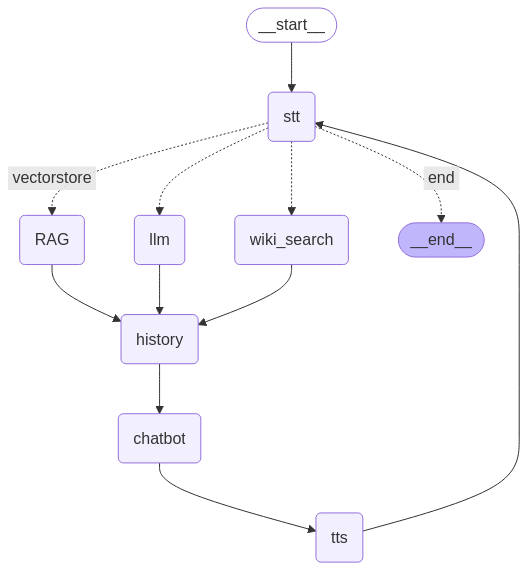

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "2"}}
response = graph.invoke({'query': ''}, config=config, stream_mode='values')

Listening... Speak now!


In [ ]:
response